In [ ]:
# Connect Google Cloud
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "deepfake_detection_datasets"  # or a location like "my-bucket/path/to/mount"
local_path = f"/content/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  13263      0 --:--:-- --:--:-- --:--:-- 13295
OK
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up g

In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!git clone https://github.com/TINF-DeepfakeEvaluierung/FTCN.git

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 656 (delta 101), reused 87 (delta 83), pack-reused 537
Receiving objects: 100% (656/656), 99.64 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (341/341), done.
Cloning into 'FTCN'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 178 (delta 46), reused 5 (delta 5), pack-reused 100
Receiving objects: 100% (178/178), 33.42 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
!pip install simplejson
!pip install filterpy
!pip install fvcore
!pip install einops
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=0bef2a9b46b9fccab51c73f4aedd186a6c2bd8dabda757b768cf5f90e8b0ee41
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=b837c764f0f5184f34848653d0a6f7d8b12cef3392a7127bddfac699ebe01071
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362

In [ ]:
!mkdir /content/FTCN/checkpoints
!cp "/content/deepfake_detection_datasets/FTCN_(model)/ftcn_tt.pth" "/content/FTCN/checkpoints/"

In [ ]:
import torch
from torch.utils.model_zoo import load_url
from scipy.special import expit
from sklearn.preprocessing import normalize
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import shutil
import os
import sys
from itertools import islice

In [ ]:
sys.path.append('./icpr2020dfdc')
sys.path.append('./FTCN')


from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils
from test_on_raw_video import predict_deepfake_video

Downloading: "https://github.com/yinglinzheng/face_weights/releases/download/v1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth
100%|██████████| 1.71M/1.71M [00:00<00:00, 121MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/yinglinzheng/face_weights/releases/download/v1/mobilenet_224_model_best_gdconv_external.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_224_model_best_gdconv_external.pth
100%|██████████| 14.5M/14.5M [00:00<00:00, 210MB/s]


In [ ]:
net_model = 'EfficientNetB4'
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 109MB/s]


Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth
100%|██████████| 33.9M/33.9M [00:03<00:00, 11.0MB/s]


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("/content/icpr2020dfdc/blazeface/blazeface.pth")
facedet.load_anchors("/content/icpr2020dfdc/blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

In [ ]:
def get_combined_scores_weighted(model1_scores_real, model1_scores_fake, model2_scores_real, model2_scores_fake, weight = 1):
  if len(model1_scores_real) == len(model2_scores_real):
    number_reals = len(model1_scores_real)
  else:
    raise Exception(f"Results do not have the same number of real scores")

  if len(model1_scores_fake) == len(model2_scores_fake):
    number_fakes = len(model1_scores_fake)
  else:
    raise Exception(f"Results do not have the same number of fake scores")

  scores_real = np.array([])
  scores_fake = np.array([])

  # Eigentlich sollte immer der größere wert mit der gewichtung Multipliziert werden,
  # da normalerweise nicht bekannt ist ob es sich um einen deepfake handelt oder nicht
  # Begründung könnte sein:
  # Wenn ein Model ein Video als Deepfake erkennt, sollte das model stärker gewichtet werden
  # => es ist wichtiger deepfakes wirklich als deepfakes zu identifizieren, als echte bilder als echt zu Klassifizieren
  # => Endaussage: Die Wahrscheinlichkeit ist hoch dass es ein Deepfake ist
  for i in range(number_reals):
    if model1_scores_real[i] > model2_scores_real[i]:
      real = (model1_scores_real[i] * weight + model2_scores_real[i]) / (weight + 1)
    else:
      real = (model1_scores_real[i] + model2_scores_real[i] * weight) / (weight + 1)

    scores_real = np.append(scores_real, real)

  for i in range(number_fakes):
    if model1_scores_fake[i] > model2_scores_fake[i]:
      fake = (model1_scores_fake[i] * weight + model2_scores_fake[i]) / (weight + 1)
    else:
      fake = (model1_scores_fake[i] + model2_scores_fake[i] * weight) / (weight + 1)

    scores_fake = np.append(scores_fake, fake)

  return scores_real, scores_fake

In [ ]:
def get_combined_scores_threshold(uper_threshold, model1_scores_real, model1_scores_fake, model2_scores_real, model2_scores_fake, weight = 4):
  if len(model1_scores_real) == len(model2_scores_real):
    number_reals = len(model1_scores_real)
  else:
    raise Exception(f"Results do not have the same number of real scores")

  if len(model1_scores_fake) == len(model2_scores_fake):
    number_fakes = len(model1_scores_fake)
  else:
    raise Exception(f"Results do not have the same number of fake scores")

  scores_real = np.array([])
  scores_fake = np.array([])

  lower_threshold = 1 - uper_threshold

  # echte und fake Videos müssen gleich behandelt werden, da man normlerweiße nicht weiß welches Video echt oder fake ist
  # sagen beide modele das Video ist fake wird beiden modelen ein bonus gegeben und der mittelwert gebildet
  # sagen beide modele das Video ist echt wird beiden modelen ein malus gegeben und der mittelwert gebildet
  # anderenfalls wird geschaut welches model sich "sicherer" ist (weiter weg von 0.5) und das model mit der höreren distanz wird stärker gewichtet
  for i in range(number_reals):
    if model1_scores_real[i] > uper_threshold and model2_scores_real[i] > uper_threshold:
      real = ((model1_scores_real[i] + 1) + (model2_scores_real[i] + 1)) / 4
    elif model1_scores_real[i] > uper_threshold:
      real = ((model1_scores_real[i] + 1) + (model2_scores_real[i])) / 3
    elif model2_scores_real[i] > uper_threshold:
      real = ((model1_scores_real[i]) + (model2_scores_real[i] + 1)) / 3
    elif model1_scores_real[i] < lower_threshold and model2_scores_real[i] < lower_threshold:
      real = ((model1_scores_real[i] / 2) + (model2_scores_real[i] / 2)) / 2
    elif model1_scores_real[i] < lower_threshold:
      real = ((model1_scores_real[i]) + (model2_scores_real[i] / 2)) / 2
    elif model2_scores_real[i] < lower_threshold:
      real = ((model1_scores_real[i] / 2) + (model2_scores_real[i])) / 2
    else:
      model1_dist = np.abs(model1_scores_real[i] - 0.5)
      model2_dist = np.abs(model2_scores_real[i] - 0.5)
      if model1_dist > model2_dist:
        real = ((model1_scores_real[i] * weight) + model2_scores_real[i]) / (weight + 1)
      else:
        real = (model1_scores_real[i] + (model2_scores_real[i] * weight)) / (weight + 1)

    scores_real = np.append(scores_real, real)

  for i in range(number_fakes):
    if model1_scores_fake[i] > uper_threshold and model2_scores_fake[i] > uper_threshold:
      fake = ((model1_scores_fake[i] + 1) + (model2_scores_fake[i] + 1)) / 4
    elif model1_scores_fake[i] > uper_threshold:
      fake = ((model1_scores_fake[i] + 1) + (model2_scores_fake[i])) / 3
    elif model2_scores_fake[i] > uper_threshold:
      fake = ((model1_scores_fake[i]) + (model2_scores_fake[i] + 1)) / 3
    elif model1_scores_fake[i] < lower_threshold and model2_scores_fake[i] < lower_threshold:
      fake = ((model1_scores_fake[i] / 2) + (model2_scores_fake[i] / 2)) / 2
    elif model1_scores_fake[i] < lower_threshold:
      fake = ((model1_scores_fake[i]) + (model2_scores_fake[i] / 2)) / 2
    elif model2_scores_fake[i] < lower_threshold:
      fake = ((model1_scores_fake[i] / 2) + (model2_scores_fake[i])) / 2
    else:
      model1_dist = np.abs(model1_scores_fake[i] - 0.5)
      model2_dist = np.abs(model2_scores_fake[i] - 0.5)
      if model1_dist > model2_dist:
        fake = ((model1_scores_fake[i] * weight) + model2_scores_fake[i]) / (weight + 1)
      else:
        fake = (model1_scores_fake[i] + (model2_scores_fake[i] * weight)) / (weight + 1)

    scores_fake = np.append(scores_fake, fake)

  return scores_real, scores_fake

## Celeb-DF

In [ ]:
real_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-real"
fake_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis"
dataset = "CelebDF"

In [ ]:
def detect_celeb_deepfake(deepfake_folder, num_videos=50):
  ftcn_scores = np.array([]);
  efficient_scores = np.array([]);
  for deepfake in tqdm(islice(os.listdir(deepfake_folder), num_videos), total=num_videos):
    if deepfake.endswith('.mp4'):
      vid_path = os.path.join(deepfake_folder, deepfake)
      vid = face_extractor.process_video(vid_path)

      # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
      faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

      with torch.no_grad():
         efficient_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

      ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")

      ftcn_scores = np.append(ftcn_scores, ftcn_faces_pred)
      efficient_scores = np.append(efficient_scores, expit(efficient_faces_pred.mean()))
  return efficient_scores, ftcn_scores

In [ ]:
efficientNet_celeb_score_real, ftcn_celeb_score_real = detect_celeb_deepfake(real_celeb_dir)
efficientNet_celeb_score_fake, ftcn_celeb_score_fake = detect_celeb_deepfake(fake_celeb_dir)

In [ ]:
efficientNet_celeb_score_real = np.array([0.09781378,0.53271574,0.01429813,0.01600956,0.0098398,0.02513279,
                                          0.13536356,0.00588785,0.01405864,0.03478229,0.01432775,0.14858142,
                                          0.00541533,0.00350287,0.02328011,0.01891061,0.25195757,0.02818949,
                                          0.51474148,0.00499868,0.01103462,0.01858471,0.24266583,0.15095511,
                                          0.00760541,0.06040677,0.07242939,0.01118591,0.00875281,0.04370009,
                                          0.01167931,0.03629787,0.12631029,0.66262913,0.04309213,0.01776471,
                                          0.05440234,0.08009622,0.02935691,0.00973666,0.02433397,0.09150486,
                                          0.02218608,0.01080059,0.02196215,0.18410683,0.01681298,0.36652592,
                                          0.74683076,0.02342175
                                          ])
efficientNet_celeb_score_fake = np.array([0.38558289,0.97760618,0.96469295,0.59281754,0.70524263,0.92630696,
                                          0.11680405,0.96550250,0.73078263,0.79785866,0.57440984,0.23127247,
                                          0.97015923,0.68121153,0.86842638,0.33958393,0.80984253,0.99623257,
                                          0.35312021,0.79519427,0.12422355,0.99684274,0.76946247,0.84466594,
                                          0.99952269,0.44711754,0.97733092,0.15621591,0.98858917,0.99533302,
                                          0.98594266,0.99884534,0.99268603,0.61436993,0.66564238,0.75978494,
                                          0.58136356,0.80063581,0.92903221,0.99393231,0.98815244,0.99680007,
                                          0.37586778,0.55371535,0.99628484,0.99792552,0.99941599,0.26640981,
                                          0.68806595,0.97671324
                                          ])
ftcn_celeb_score_real = np.array([0.26513605,0.01818914,0.03837477,0.00858360,0.00377256,0.02439076,
                                  0.04932197,0.06903075,0.05349942,0.11021198,0.18908804,0.08803745,
                                  0.24484966,0.03888367,0.16249944,0.02655514,0.13623565,0.01633795,
                                  0.13347630,0.00096064,0.00052952,0.00543093,0.01459233,0.04174246,
                                  0.03602857,0.00875477,0.04972837,0.01804283,0.11683710,0.01585600,
                                  0.02516194,0.11048172,0.02702564,0.05956698,0.00938310,0.00302228,
                                  0.02560765,0.05279265,0.09162889,0.06184931,0.03483844,0.06172064,
                                  0.03129257,0.01638103,0.06912571,0.11363236,0.02644193,0.04027476,
                                  0.14152508,0.00591206
                                  ])
old_ftcn_celeb_score_fake = np.array([0.44961509, 0.03121203, 0.51265178, 0.12200155, 0.26305259, 0.26477856,
                                  0.13885899, 0.17114731, 0.22397778, 0.25638672, 0.43759812, 0.05152407,
                                  0.56052518, 0.10913341, 0.23769576, 0.162139  , 0.22919661, 0.32446928,
                                  0.55877463, 0.03845513, 0.46645392, 0.26894028, 0.2512923 , 0.14769633,
                                  0.181253  , 0.37822175, 0.70466051, 0.0748384 , 0.63118881, 0.39931155,
                                  0.44557823, 0.46519728, 0.2800967 , 0.53484149, 0.44090149, 0.63283269,
                                  0.07266141, 0.64239974, 0.28954278, 0.38154916, 0.45233635, 0.17312505,
                                  0.69373051, 0.28308325, 0.58586962, 0.08403844, 0.63791946, 0.45338423,
                                  0.55375033, 0.78773358])
ftcn_celeb_score_fake = np.array([0.14201569,0.08697716,0.19166802,0.39324300,0.24235911,0.21343795,
                                  0.14353237,0.28513006,0.19489677,0.15430312,0.15593044,0.36649471,
                                  0.35459456,0.75645000,0.10913570,0.11990473,0.12093643,0.49159603,
                                  0.54956442,0.34150059,0.16102676,0.52413824,0.24753789,0.11365732,
                                  0.21720479,0.00491173,0.40634073,0.26953840,0.35158966,0.28605570,
                                  0.00464092,0.22104641,0.19497071,0.79711661,0.39321749,0.11614539,
                                  0.06431277,0.52053147,0.35989986,0.40179553,0.03661453,0.10449919,
                                  0.25163531,0.29685542,0.11684790,0.01413263,0.49858501,0.13037399,
                                  0.12399768,0.06097522
                                  ])

In [ ]:
combined_celeb_scores_real = np.array([0.209361960,0.36120687,0.03034922,0.01353424,0.00781739,0.02488545
                                      ,0.10668303,0.04798312,0.04035249,0.08506875,0.13083461,0.12840010
                                      ,0.16503822,0.02709007,0.11609300,0.02400696,0.21338360,0.02423898
                                      ,0.38765309,0.00365267,0.00753292,0.01420012,0.16664133,0.11455089
                                      ,0.02655418,0.04318944,0.06486238,0.01575719,0.08080900,0.03441873
                                      ,0.02066773,0.08575377,0.09321541,0.46160841,0.03185579,0.01285057
                                      ,0.04480411,0.07099503,0.07087156,0.04447843,0.03133695,0.08157679
                                      ,0.02825707,0.01452088,0.05340452,0.16061534,0.02323228,0.25777553
                                      ,0.54506220,0.01758519])

combined_celeb_scores_fake = np.array([0.304393820,0.68072984,0.70701797,0.52629269,0.55094812,0.68868396
                                      ,0.13462293,0.73871169,0.55215401,0.58334015,0.43491671,0.32142063
                                      ,0.76497101,0.73137051,0.61532949,0.26635753,0.58020716,0.82802039
                                      ,0.48408302,0.64396304,0.14875902,0.83927457,0.59548761,0.60099640
                                      ,0.73875006,0.29971560,0.78700086,0.23176424,0.77625600,0.75890725
                                      ,0.65884208,0.73957903,0.72678092,0.73620105,0.57483408,0.54523842
                                      ,0.40901330,0.70726770,0.73932143,0.79655338,0.67097314,0.69936644
                                      ,0.33445696,0.46809537,0.70313919,0.66999456,0.83247233,0.22106454
                                      ,0.50004319,0.67146723])

In [ ]:
combined_celeb_scores_real, combined_celeb_scores_fake = get_combined_scores_threshold(0.5, efficientNet_celeb_score_real, efficientNet_celeb_score_fake,
                                                                                      ftcn_celeb_score_real, ftcn_celeb_score_fake, 4)

In [ ]:
combined_celeb_scores_real = combined_celeb_scores_real[:30]
combined_celeb_scores_fake = combined_celeb_scores_fake[:30]
ftcn_celeb_score_fake = ftcn_celeb_score_fake[:30]
ftcn_celeb_score_real = ftcn_celeb_score_real[:30]
efficientNet_celeb_score_fake = efficientNet_celeb_score_fake[:30]
efficientNet_celeb_score_real = efficientNet_celeb_score_real[:30]

### Create Diagrams

In [ ]:
dataset = "Celeb-DF"

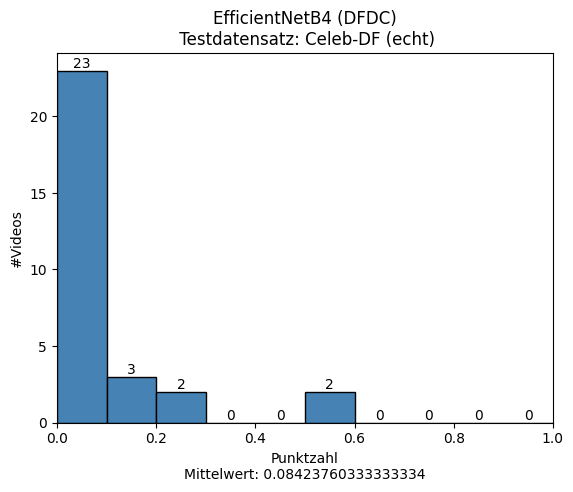

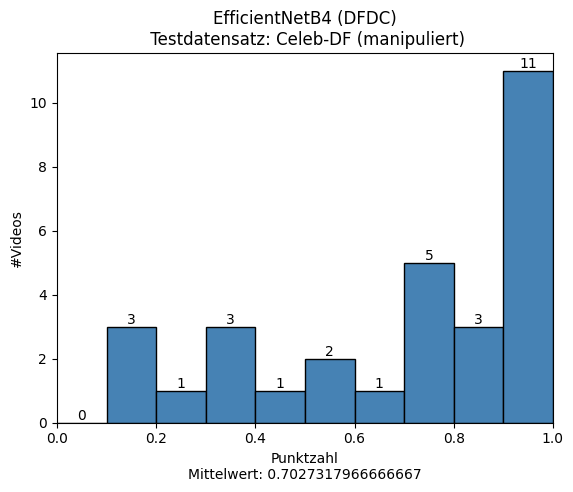

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(efficientNet_celeb_score_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {efficientNet_celeb_score_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(efficientNet_celeb_score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {efficientNet_celeb_score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

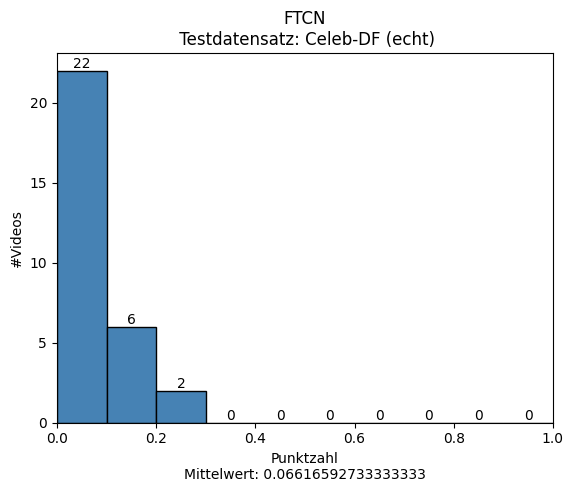

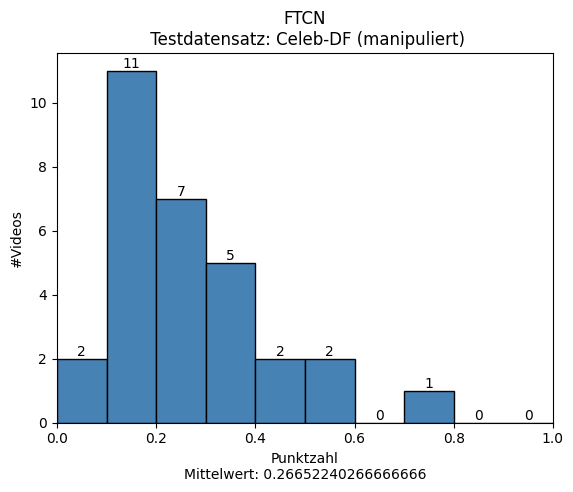

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(ftcn_celeb_score_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_celeb_score_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(ftcn_celeb_score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_celeb_score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

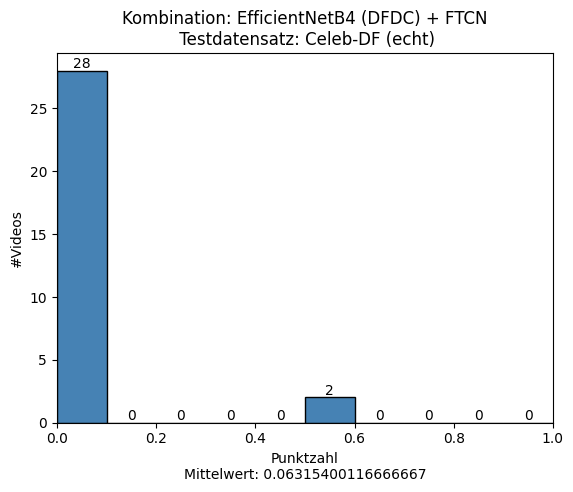

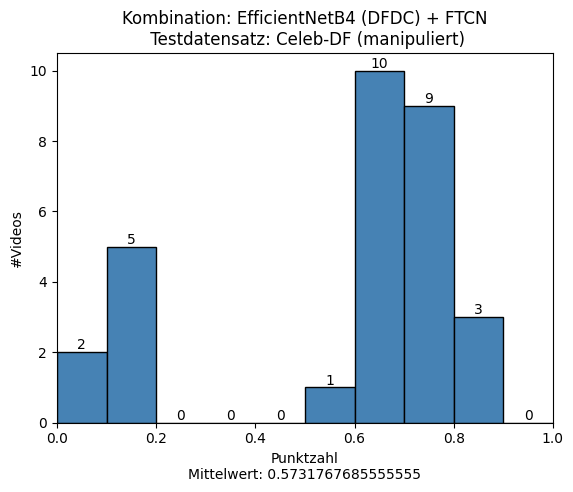

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(combined_celeb_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_celeb_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(combined_celeb_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_celeb_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(combined_celeb_scores_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_celeb_scores_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_celeb_scores_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_celeb_scores_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

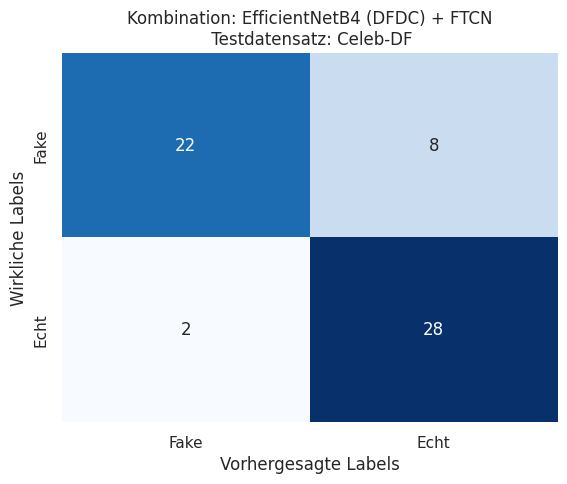

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

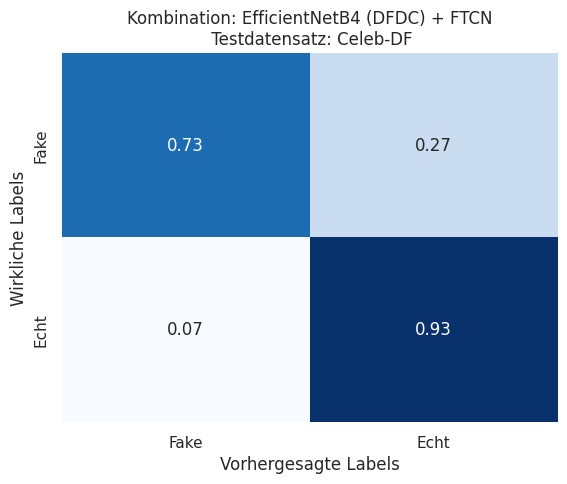

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

## FF++

In [ ]:
ffpp_dir = "/content/deepfake_detection_datasets/FFPP/"
dataset = "FaceForensics++"

In [ ]:
# images_per_class should be devidable by 6
def detect_ffpp_deepfakes(ffpp_dir, images_per_class=30):
    # Initialize arrays to store scores for real and fake videos.
    ftcn_scores_real = np.array([])
    ftcn_scores_fake = np.array([])
    enet_scores_real = np.array([])
    enet_scores_fake = np.array([])
    # Dictionaries to keep track of how many files have been processed in each subfolder.
    manipulated_predicted_count = {}
    original_predicted_count = {}

    # Calculate the number of files to be processed per subfolder based on the folder type.
    files_per_manipulated_subfolder = images_per_class / 6
    files_per_original_subfolder = images_per_class / 2

    # Total number of files targeted for processing from all subfolders.
    total_files_to_process = 2 * images_per_class
    processed_files = 0  # Counter for the number of files processed.

    # Set up a progress bar with the total number of files to process.
    pbar = tqdm(total=total_files_to_process)

    # Walk through the directory structure of the given path.
    for root, _, files in os.walk(ffpp_dir):
        for file in files:
            # Stop processing if the number of processed files meets the target.
            if processed_files >= total_files_to_process:
                break

            # Process only MP4 video files.
            if file.endswith('.mp4'):
                vid_path = os.path.join(root, file)
                rel_path = os.path.relpath(vid_path, ffpp_dir)
                path_parts = rel_path.split(os.sep)
                # Dynamically update the progress bar description.
                pbar.set_description(f"Processing {path_parts[-1]}")

                # Check if the video is from a manipulated or original sequence based on folder names.
                is_manipulated = path_parts[0] == 'manipulated_sequences'
                subfolder_path = os.path.join(path_parts[0], path_parts[1])

                # Process videos from manipulated sequences.
                if is_manipulated:
                    # Ensure not to process more videos than the set limit for the subfolder.
                    if manipulated_predicted_count.get(subfolder_path, 0) < files_per_manipulated_subfolder:
                      vid = face_extractor.process_video(vid_path)
                      faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )
                      with torch.no_grad():
                        enet_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
                      ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")
                      ftcn_scores_fake = np.append(ftcn_scores_fake, ftcn_faces_pred)
                      enet_scores_fake = np.append(enet_scores_fake, expit(enet_faces_pred.mean()))
                      manipulated_predicted_count[subfolder_path] = manipulated_predicted_count.get(subfolder_path, 0) + 1
                      processed_files += 1
                      pbar.update(1)
                # Process videos from original sequences.
                else:
                    if original_predicted_count.get(subfolder_path, 0) < files_per_original_subfolder:
                      vid = face_extractor.process_video(vid_path)
                      faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )
                      with torch.no_grad():
                        enet_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()
                      ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")
                      ftcn_scores_real = np.append(ftcn_scores_real, ftcn_faces_pred)
                      enet_scores_real = np.append(enet_scores_real, expit(enet_faces_pred.mean()))
                      original_predicted_count[subfolder_path] = original_predicted_count.get(subfolder_path, 0) + 1
                      processed_files += 1
                      pbar.update(1)

        # Break the outer loop if the processing limit is reached.
        if processed_files >= total_files_to_process:
            break

    # Close the progress bar upon completion.
    pbar.close()
    # Return the arrays containing the fake and real scores.
    return ftcn_scores_real, ftcn_scores_fake, enet_scores_real, enet_scores_fake

In [ ]:
ftcn_scores_real, ftcn_scores_fake, enet_scores_real, enet_scores_fake = detect_ffpp_deepfakes(ffpp_dir, 30)

  0%|          | 0/60 [00:00<?, ?it/s]


In [ ]:
ftcn_ffpp_scores_real = np.array([2.52206287e-01, 4.03647650e-01, 2.00568576e-02, 3.97242704e-01,
                                  5.14272313e-02, 4.17051064e-01, 2.15749985e-01, 6.44421625e-02,
                                  2.99814827e-03, 4.56042374e-01, 4.53204091e-01, 9.67739611e-01,
                                  2.47395684e-01, 3.75597782e-01, 1.13275832e-01, 1.91627104e-04,
                                  1.31107383e-01, 5.70065502e-01, 2.73494180e-03, 7.98295438e-04,
                                  1.64441197e-03, 1.78355526e-04, 3.80590423e-04, 2.37434842e-03,
                                  3.60868241e-04, 1.65245859e-02, 4.97402499e-03, 2.13251945e-02,
                                  3.83973699e-03, 1.54197696e-04])

ftcn_ffpp_scores_fake = np.array([0.82342534, 0.88378262, 0.44535495, 0.9689756 , 0.99994767,
                                  0.99996431, 0.99980052, 0.99806754, 0.9999662 , 0.99972145,
                                  0.99967121, 0.99993383, 0.99995362, 0.99990844, 0.99995546,
                                  0.93464471, 0.99644768, 0.68128946, 0.90298818, 0.81153924,
                                  0.99991022, 0.99258559, 0.88243841, 0.99995921, 0.99995893,
                                  0.99804606, 0.99992942, 0.99941511, 0.99931024, 0.99994766])

enet_ffpp_scores_real = np.array([0.00907007, 0.02576843, 0.02219854, 0.00483292, 0.00254643,
                                  0.04061216, 0.12007113, 0.2469025 , 0.71658307, 0.02849593,
                                  0.02296107, 0.49629351, 0.01493309, 0.04801973, 0.01614471,
                                  0.15554839, 0.36025593, 0.57148004, 0.68768567, 0.00499823,
                                  0.20779745, 0.18602635, 0.69839346, 0.05339609, 0.4190613 ,
                                  0.82053423, 0.08989354, 0.349206  , 0.0794313 , 0.96756202])

enet_ffpp_scores_fake = np.array([0.95339859, 0.01475146, 0.08999489, 0.99340349, 0.99746168,
                                  0.67165595, 0.99578154, 0.99759859, 0.70696962, 0.98692501,
                                  0.37819612, 0.74056375, 0.52506757, 0.02080293, 0.97291404,
                                  0.44288599, 0.94463181, 0.8343665 , 0.20700365, 0.04657795,
                                  0.60959452, 0.36316603, 0.98525673, 0.75637805, 0.99766999,
                                  0.37145761, 0.78271192, 0.60341144, 0.00634188, 0.83342457])

combined_ffpp_scores_real = np.array([0.17116088, 0.27768791, 0.02148465, 0.26643944, 0.03513363,
                                      0.29157143, 0.18385703, 0.18608239, 0.47872143, 0.31352689,
                                      0.30978975, 0.81059091, 0.16990815, 0.2664051 , 0.08089879,
                                      0.1037628 , 0.28387308, 0.57100853, 0.45936876, 0.00359825,
                                      0.13907977, 0.12407702, 0.4657225 , 0.03638884, 0.27949449,
                                      0.55253102, 0.06158703, 0.2399124 , 0.05423411, 0.64509275])

combined_ffpp_scores_fake = np.array([0.91007417, 0.59410557, 0.3269016 , 0.98526086, 0.99911901,
                                      0.89052819, 0.99846086, 0.99791122, 0.90230067, 0.99545597,
                                      0.79251285, 0.91347714, 0.84165827, 0.67353994, 0.99094165,
                                      0.77072514, 0.97917572, 0.78334082, 0.67099334, 0.55655214,
                                      0.86980499, 0.78277907, 0.95098396, 0.91876549, 0.99919595,
                                      0.78918324, 0.92752359, 0.86741389, 0.66832079, 0.94443996])

In [ ]:
combined_ffpp_scores_real, combined_ffpp_scores_fake = get_combined_scores_threshold(0.5, enet_ffpp_scores_real, enet_ffpp_scores_fake,
                                                                                        ftcn_ffpp_scores_real, ftcn_ffpp_scores_fake, 4)

### Create Diagrams

In [ ]:
dataset = "FaceForensics++"

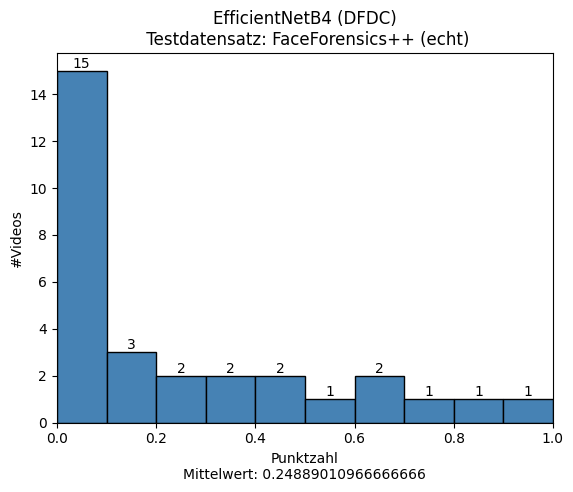

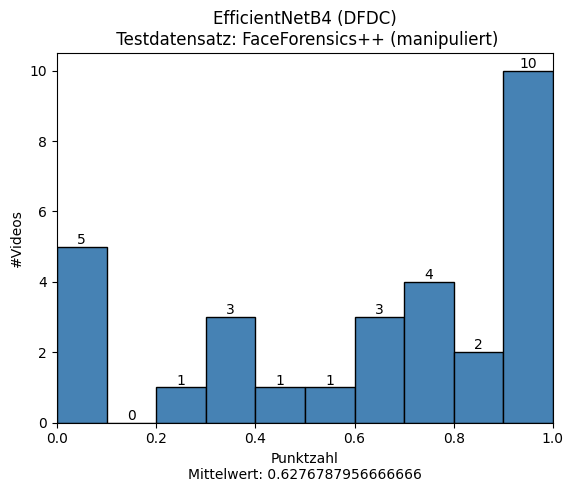

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(enet_ffpp_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_ffpp_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(enet_ffpp_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_ffpp_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

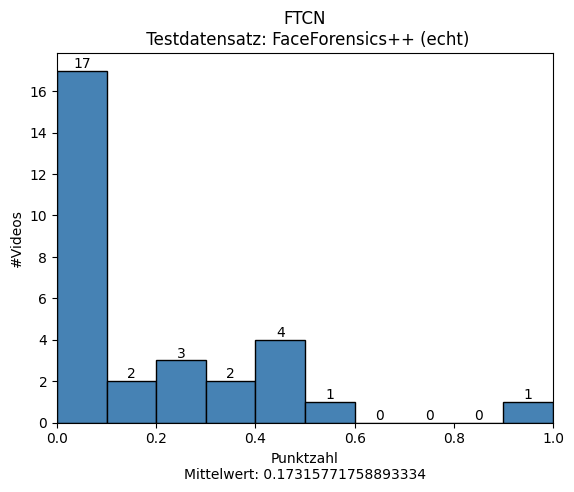

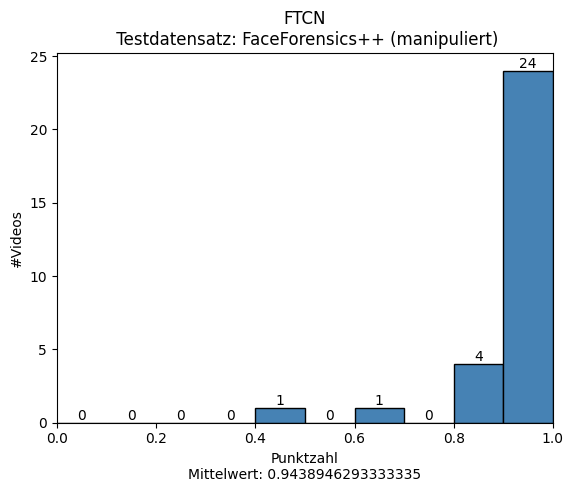

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(ftcn_ffpp_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_ffpp_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(ftcn_ffpp_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_ffpp_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

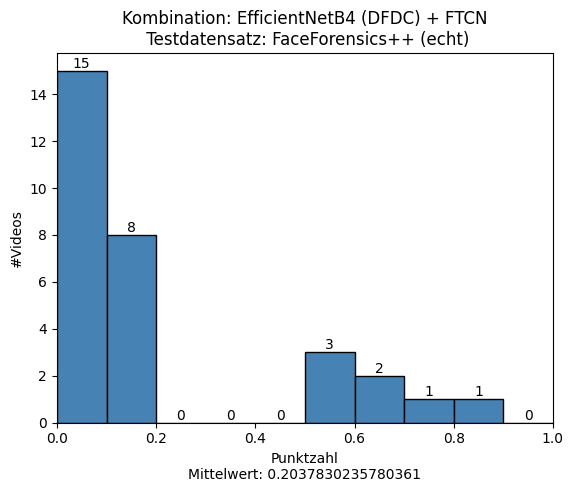

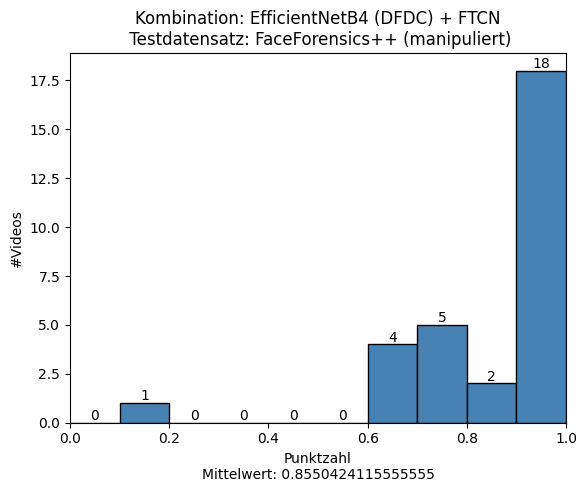

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(combined_ffpp_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_ffpp_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(combined_ffpp_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_ffpp_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(combined_ffpp_scores_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_ffpp_scores_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_ffpp_scores_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_ffpp_scores_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

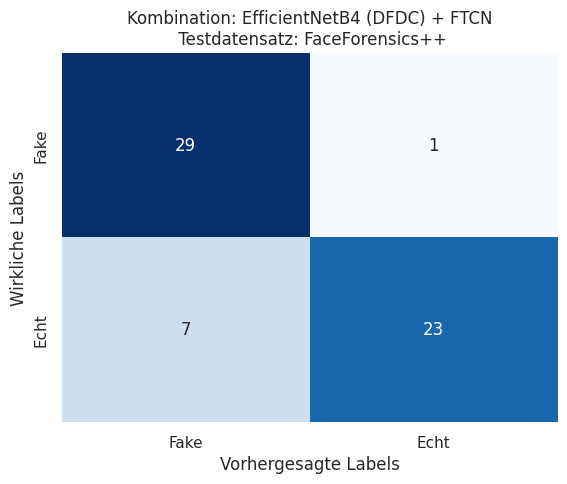

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

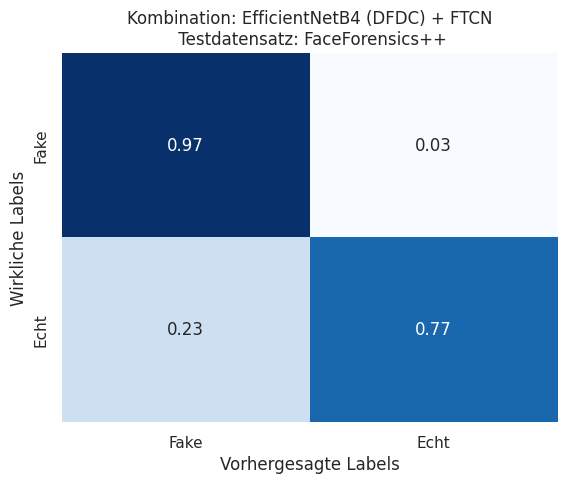

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

#### ROC AUC

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
lables = []

for i in range(len(combined_ffpp_scores_real)):
  lables.append(0)
for i in range(len(combined_ffpp_scores_fake)):
  lables.append(1)

combined_all_predictions = np.append(combined_ffpp_scores_real, combined_ffpp_scores_fake)
efficient_all_predictions = np.append(enet_ffpp_scores_real, enet_ffpp_scores_fake)
ftcn_all_predictions = np.append(ftcn_ffpp_scores_real, ftcn_ffpp_scores_fake)

In [ ]:
combined_auc = roc_auc_score(lables, combined_all_predictions)
combined_auc_fpr, combined_auc_tpr, combined_auc_thresholds = roc_curve(lables, combined_all_predictions, pos_label=1)

efficient_auc = roc_auc_score(lables, efficient_all_predictions)
efficient_auc_fpr, efficient_auc_tpr, efficient_auc_thresholds = roc_curve(lables, efficient_all_predictions, pos_label=1)

ftcn_auc = roc_auc_score(lables, ftcn_all_predictions)
ftcn_auc_fpr, ftcn_auc_tpr, ftcn_auc_thresholds = roc_curve(lables, ftcn_all_predictions, pos_label=1)

Optimaler Threshold: 0.6193723966666668


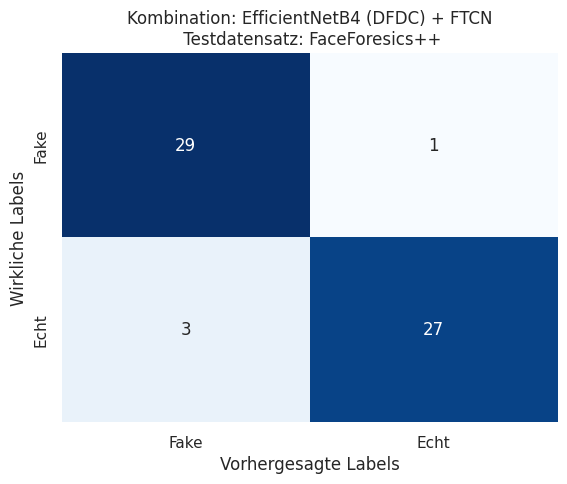

In [ ]:
dataset = "FaceForesics++"
optimal_idx = np.argmax(combined_auc_tpr - combined_auc_fpr)
optimal_threshold = combined_auc_thresholds[optimal_idx]
print(f"Optimaler Threshold: {optimal_threshold}")

# Getting Data
TP = np.sum(combined_ffpp_scores_fake >= optimal_threshold) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_ffpp_scores_fake < optimal_threshold) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_ffpp_scores_real >= optimal_threshold) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_ffpp_scores_real < optimal_threshold) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

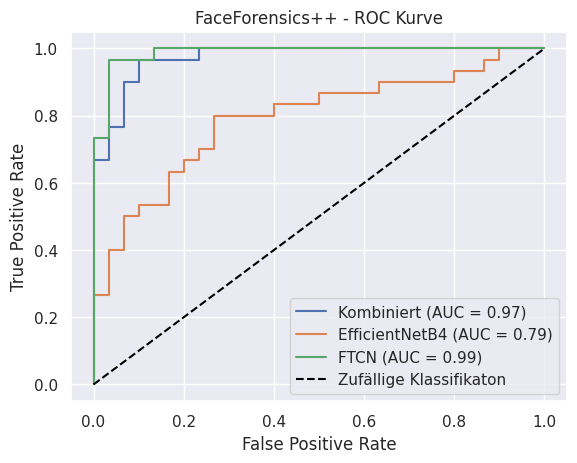

In [ ]:
plt.plot(combined_auc_fpr, combined_auc_tpr, label=f'Kombiniert (AUC = %0.2f)' % combined_auc)
plt.plot(efficient_auc_fpr, efficient_auc_tpr, label=f'EfficientNetB4 (AUC = %0.2f)' % efficient_auc)
plt.plot(ftcn_auc_fpr, ftcn_auc_tpr, label=f'FTCN (AUC = %0.2f)' % ftcn_auc)

# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Zufällige Klassifikaton')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'FaceForensics++ - ROC Kurve')
plt.legend(loc="lower right")
plt.show()

## FakeAVCeleb

In [ ]:
fakeavceleb_metadata = "/content/deepfake_detection_datasets/FakeAVCeleb/meta_data.csv"
dataset = "FakeAVCeleb"

In [ ]:
# files_per_class must be devidable by 10
def detect_fakeAVCeleb_deepfake(metadata_file, videos_per_class=30):
  metadata = pd.read_csv(metadata_file)

  ftcn_scores_real = np.array([]);
  ftcn_scores_fake = np.array([]);
  enet_scores_real = np.array([]);
  enet_scores_fake = np.array([]);

  # Filter for 'RealVideo-RealAudio' category
  real_videos = metadata[metadata['type'] == 'RealVideo-RealAudio'].head(videos_per_class)

  videos_per_fake_class = int(videos_per_class/10)
  # Filter for 'FakeVideo-RealAudio' category and sample
  fake_videos = metadata[metadata['type'] == 'FakeVideo-RealAudio']
  sampled_fakes = fake_videos.groupby(['race', 'gender']).apply(
        lambda x: x.sample(n=videos_per_fake_class, replace=False) if len(x) >= videos_per_fake_class else x).reset_index(drop=True)

  # Concatenate real and sampled fake videos
  final_metadata = pd.concat([real_videos, sampled_fakes]).reset_index(drop=True)

  for index, properties in tqdm(final_metadata.iterrows(), total=len(final_metadata.index)):
    vid_path = os.path.join("/content/deepfake_detection_datasets/", properties['Unnamed: 9'], properties['path'])
    vid = face_extractor.process_video(vid_path)

    # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
    faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

    with torch.no_grad():
        enet_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

    ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")

    if properties['method'] == "real":
      ftcn_scores_real = np.append(ftcn_scores_real, ftcn_faces_pred.mean())
      enet_scores_real = np.append(enet_scores_real, expit(enet_faces_pred.mean()))
    else:
      ftcn_scores_fake = np.append(ftcn_scores_fake, ftcn_faces_pred.mean())
      enet_scores_fake = np.append(enet_scores_fake, expit(enet_faces_pred.mean()))

  return ftcn_scores_real, ftcn_scores_fake, enet_scores_real, enet_scores_fake

In [ ]:
ftcn_fakeav_scores_real, ftcn_fakeav_scores_fake, enet_fakeav_scores_real, enet_fakeav_scores_fake = detect_fakeAVCeleb_deepfake(fakeavceleb_metadata)

In [ ]:
ftcn_fakeav_scores_real = np.array([0.28671733, 0.42851003, 0.14347353, 0.56999136, 0.16403491,
                                    0.25805836, 0.39683751, 0.98423146, 0.62128354, 0.91647133,
                                    0.48210416, 0.81684206, 0.31409529, 0.61605597, 0.5106201 ,
                                    0.86423771, 0.90975521, 0.95123346, 0.28897385, 0.15811866,
                                    0.53482028, 0.19414833, 0.52285503, 0.09118649, 0.50522452,
                                    0.37519364, 0.29324729, 0.17031526, 0.47806499, 0.98668832])

ftcn_fakeav_scores_fake = np.array([0.97596469, 0.99962079, 0.62023181, 0.58860539, 0.59577146,
                                    0.85136439, 0.97973001, 0.77149935, 0.99957905, 0.89882605,
                                    0.92157025, 0.61359564, 0.9102583 , 0.92780937, 0.70447536,
                                    0.99940171, 0.99993951, 0.99990661, 0.99000379, 0.99538675,
                                    0.99967438, 0.99894292, 0.99987898, 0.5717094 , 0.98038056,
                                    0.40882068, 0.97620908, 0.96389532, 0.96294584, 0.99965864])

enet_fakeav_scores_real = np.array([0.21947651, 0.05079558, 0.52279627, 0.16422288, 0.91180098,
                                    0.05564242, 0.75495929, 0.18240793, 0.79068434, 0.87972593,
                                    0.86694771, 0.61162108, 0.5564909 , 0.84533405, 0.35535145,
                                    0.0817221 , 0.24172054, 0.42424506, 0.04344146, 0.06973071,
                                    0.44236889, 0.9430325 , 0.29950449, 0.56440496, 0.04482575,
                                    0.79903001, 0.50067782, 0.13257943, 0.99073821, 0.01581481])

enet_fakeav_scores_fake = np.array([0.73806649, 0.94294274, 0.03873369, 0.89637941, 0.65156341,
                                    0.54692918, 0.65883833, 0.68407011, 0.99112588, 0.59193999,
                                    0.21223526, 0.23452011, 0.27897564, 0.55476969, 0.32753518,
                                    0.99275863, 0.70667773, 0.24901877, 0.03785489, 0.07796182,
                                    0.97133046, 0.66141546, 0.91713929, 0.94448131, 0.89728433,
                                    0.97125816, 0.95289171, 0.02008525, 0.64154744, 0.31307149])

combined_fakeav_scores_real = np.array([0.26990713, 0.33408142, 0.42796559, 0.46854924, 0.72485946,
                                        0.20745438, 0.66542884, 0.78377558, 0.74833414, 0.90728498,
                                        0.77073682, 0.76553682, 0.495892  , 0.78801453, 0.47180294,
                                        0.6686088 , 0.74274654, 0.81948636, 0.22759075, 0.13602167,
                                        0.51170744, 0.75581146, 0.4670174 , 0.44610035, 0.39012483,
                                        0.69307091, 0.44882019, 0.1608813 , 0.86256991, 0.74396995])

combined_fakeav_scores_fake = np.array([0.91649014, 0.98545128, 0.47485728, 0.81943591, 0.63761542,
                                        0.77525559, 0.89950709, 0.74964204, 0.99746576, 0.82210454,
                                        0.7442365 , 0.51882676, 0.75243763, 0.83454945, 0.61024031,
                                        0.99774094, 0.92662407, 0.81218465, 0.75196657, 0.76603051,
                                        0.9925884 , 0.91456106, 0.97919406, 0.85128834, 0.9596065 ,
                                        0.83064879, 0.97037974, 0.7279428 , 0.88259624, 0.82801185])

In [ ]:
combined_fakeav_scores_real, combined_fakeav_scores_fake = get_combined_scores_threshold(0.5, enet_fakeav_scores_real, enet_fakeav_scores_fake,
                                                                                        ftcn_fakeav_scores_real, ftcn_fakeav_scores_fake, 4)

### Create Diagrams

In [ ]:
dataset = "FakeAvCeleb"

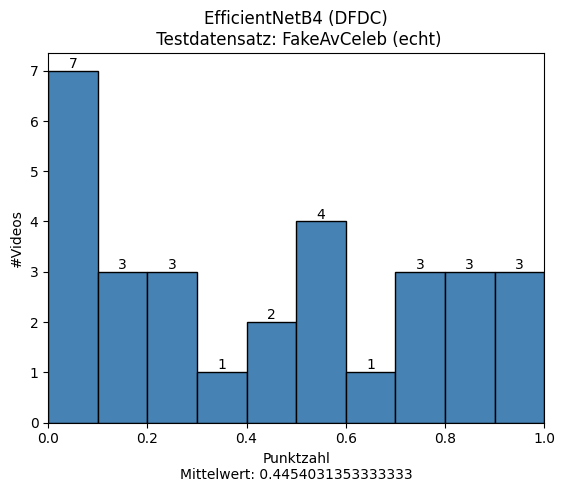

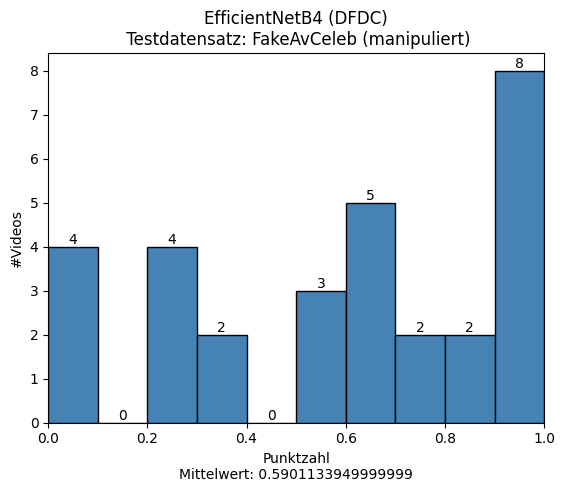

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(enet_fakeav_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_fakeav_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(enet_fakeav_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_fakeav_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

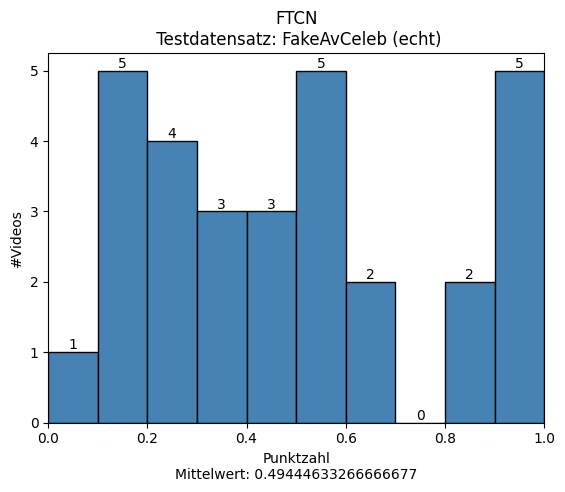

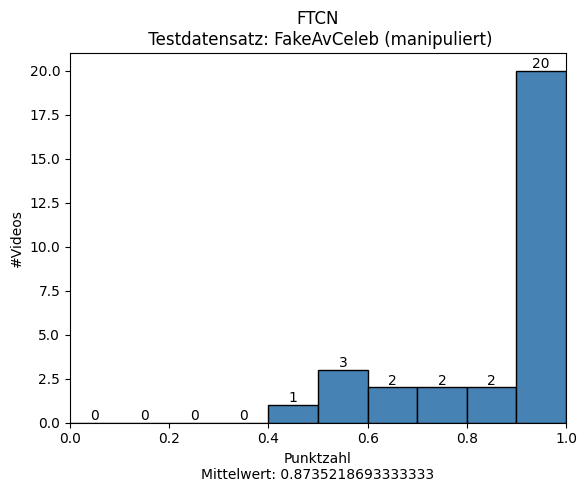

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(ftcn_fakeav_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_fakeav_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(ftcn_fakeav_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_fakeav_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

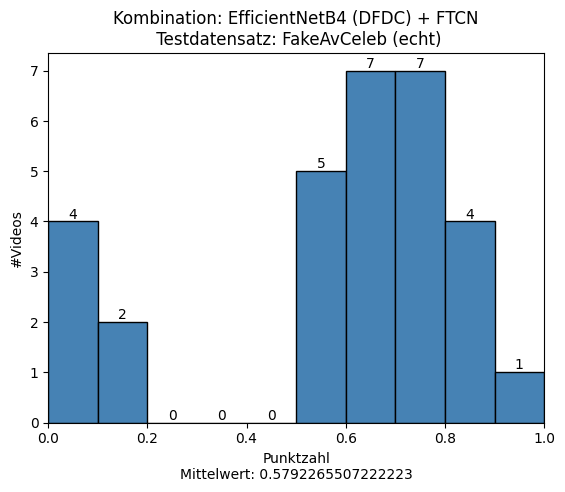

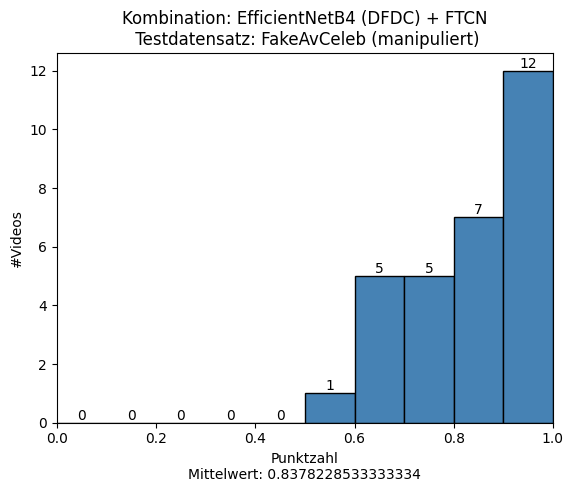

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(combined_fakeav_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_fakeav_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(combined_fakeav_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_fakeav_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(combined_fakeav_scores_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_fakeav_scores_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_fakeav_scores_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_fakeav_scores_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

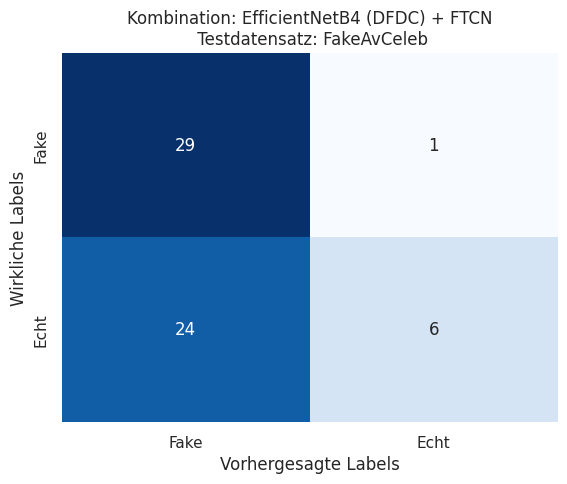

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

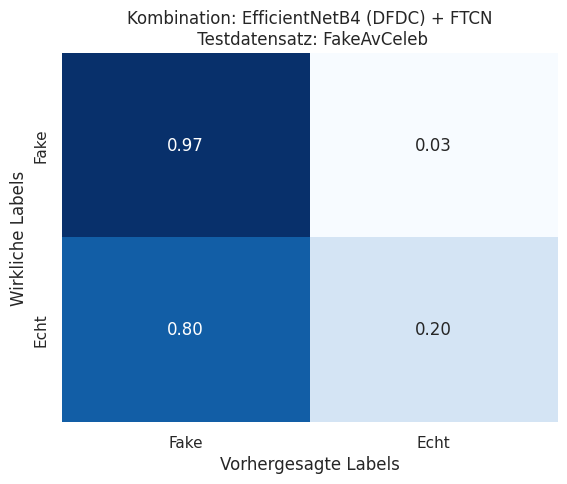

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

#### ROC AUC

In [ ]:
lables = []

for i in range(len(combined_fakeav_scores_real)):
  lables.append(0)
for i in range(len(combined_fakeav_scores_fake)):
  lables.append(1)

combined_all_predictions = np.append(combined_fakeav_scores_real, combined_fakeav_scores_fake)
efficient_all_predictions = np.append(enet_fakeav_scores_real, enet_fakeav_scores_fake)
ftcn_all_predictions = np.append(ftcn_fakeav_scores_real, ftcn_fakeav_scores_fake)

In [ ]:
combined_auc = roc_auc_score(lables, combined_all_predictions)
combined_auc_fpr, combined_auc_tpr, combined_auc_thresholds = roc_curve(lables, combined_all_predictions, pos_label=1)

efficient_auc = roc_auc_score(lables, efficient_all_predictions)
efficient_auc_fpr, efficient_auc_tpr, efficient_auc_thresholds = roc_curve(lables, efficient_all_predictions, pos_label=1)

ftcn_auc = roc_auc_score(lables, ftcn_all_predictions)
ftcn_auc_fpr, ftcn_auc_tpr, ftcn_auc_thresholds = roc_curve(lables, ftcn_all_predictions, pos_label=1)

In [ ]:
ftcn_auc_thresholds

array([1.99993951, 0.99993951, 0.99000379, 0.98423146, 0.96294584,
       0.95123346, 0.92157025, 0.91647133, 0.9102583 , 0.90975521,
       0.89882605, 0.86423771, 0.85136439, 0.81684206, 0.70447536,
       0.62128354, 0.62023181, 0.61605597, 0.5717094 , 0.42851003,
       0.40882068, 0.09118649])

Optimaler Threshold: 0.7297446466666666


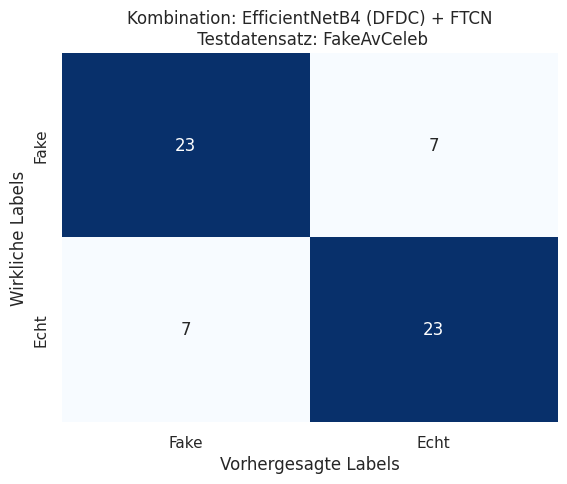

In [ ]:
dataset = "FakeAvCeleb"
optimal_idx = np.argmax(combined_auc_tpr - combined_auc_fpr)
optimal_threshold = combined_auc_thresholds[optimal_idx]
print(f"Optimaler Threshold: {optimal_threshold}")

# Getting Data
TP = np.sum(combined_fakeav_scores_fake >= optimal_threshold) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_fakeav_scores_fake < optimal_threshold) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_fakeav_scores_real >= optimal_threshold) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_fakeav_scores_real < optimal_threshold) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

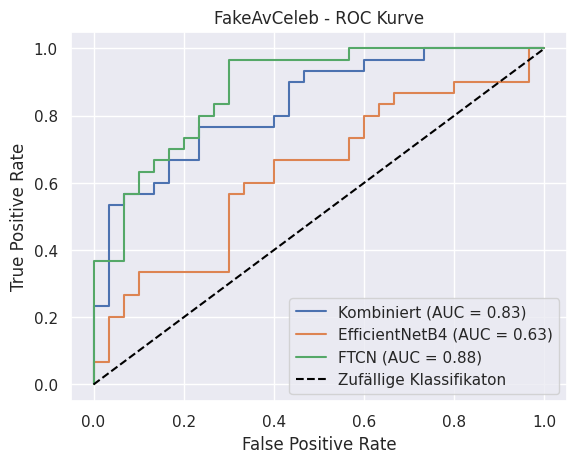

In [ ]:
plt.plot(combined_auc_fpr, combined_auc_tpr, label=f'Kombiniert (AUC = %0.2f)' % combined_auc)
plt.plot(efficient_auc_fpr, efficient_auc_tpr, label=f'EfficientNetB4 (AUC = %0.2f)' % efficient_auc)
plt.plot(ftcn_auc_fpr, ftcn_auc_tpr, label=f'FTCN (AUC = %0.2f)' % ftcn_auc)

# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Zufällige Klassifikaton')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{dataset} - ROC Kurve')
plt.legend(loc="lower right")
plt.show()

## DFDC

In [ ]:
dfdc_dir = "/content/deepfake_detection_datasets/DFDC/train_sample_videos"
dataset = "DFDC"

In [ ]:
# videos_per_class can not be bigger then 77 because there are only 77 real videos
def detect_dfdc_deepfake(deepfake_folder, videos_per_class=30):
  metadata_file = deepfake_folder + "/metadata.json"
  video_count = {'REAL': 0, 'FAKE': 0}
  pbar = tqdm(total=videos_per_class*2)

  with open(metadata_file, 'r') as file:
      metadata = json.load(file)

  ftcn_scores_real = np.array([]);
  ftcn_scores_fake = np.array([]);
  enet_scores_real = np.array([]);
  enet_scores_fake = np.array([]);

  for deepfake, properties in metadata.items():
    if video_count[properties['label']] < videos_per_class:
      vid_path = os.path.join(deepfake_folder, deepfake)
      vid = face_extractor.process_video(vid_path)

      # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
      faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

      with torch.no_grad():
          enet_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

      ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")

      if properties['label'] == "FAKE":
        enet_scores_fake = np.append(enet_scores_fake, expit(enet_faces_pred.mean()))
        ftcn_scores_fake = np.append(ftcn_scores_fake, ftcn_faces_pred)
        video_count['FAKE'] += 1
      else:
        enet_scores_real = np.append(enet_scores_real, expit(enet_faces_pred.mean()))
        ftcn_scores_real = np.append(ftcn_scores_real, ftcn_faces_pred)
        video_count['REAL'] += 1
      pbar.update(1)

  pbar.close()
  return ftcn_scores_real, ftcn_scores_fake, enet_scores_real, enet_scores_fake

In [ ]:
ftcn_dfdc_scores_real, ftcn_dfdc_scores_fake, enet_dfdc_scores_real, enet_dfdc_scores_fake = detect_dfdc_deepfake(dfdc_dir, 30)

In [ ]:
ftcn_dfdc_scores_real = np.array([3.12895020e-01, 2.30333855e-03, 2.05766832e-04, 4.84846680e-01,
                                  1.79612783e-03, 3.83204067e-02, 6.20429676e-01, 8.87592017e-01,
                                  2.69684551e-01, 5.18878114e-01, 3.46746172e-02, 3.35562862e-01,
                                  2.90196947e-03, 8.28401446e-01, 6.20778715e-01, 4.66962266e-01,
                                  2.22232950e-01, 5.70601522e-01, 3.75558933e-01, 2.71219420e-01,
                                  1.01835444e-01, 1.56257647e-01, 7.77375678e-01, 4.65184994e-01,
                                  4.18651425e-01, 3.66137937e-01, 3.12598708e-01, 7.41000900e-02,
                                  3.67294823e-01, 4.99454497e-01])

ftcn_dfdc_scores_fake = np.array([0.70286368, 0.8507046 , 0.75745433, 0.73178163, 0.96642255,
                                  0.58494453, 0.9935144 , 0.52426155, 0.68755083, 0.67709936,
                                  0.51685966, 0.99884104, 0.99983054, 0.85182517, 0.86746124,
                                  0.99863854, 0.99902547, 0.72746152, 0.96573435, 0.83800339,
                                  0.56579701, 0.98807927, 0.99645093, 0.97131347, 0.86326265,
                                  0.83303818, 0.89761486, 0.90953135, 0.82820261, 0.78714004])

enet_dfdc_scores_real = np.array([0.00717343, 0.09184226, 0.01718505, 0.30492315, 0.04823687,
                                  0.01128616, 0.12773862, 0.26509228, 0.00306061, 0.85518336,
                                  0.02670633, 0.02678985, 0.05382124, 0.27813622, 0.02423394,
                                  0.00174757, 0.00515257, 0.04959159, 0.01928184, 0.0036472 ,
                                  0.04126693, 0.05272204, 0.46540213, 0.01204948, 0.00612146,
                                  0.0056761 , 0.24943064, 0.16684757, 0.28625026, 0.06360426])

enet_dfdc_scores_fake = np.array([0.97783387, 0.81858128, 0.96912587, 0.99945623, 0.86632264,
                                  0.99832481, 0.9989379 , 0.99759418, 0.99897003, 0.95639831,
                                  0.99078649, 0.99979693, 0.99813986, 0.9990465 , 0.97247124,
                                  0.99745697, 0.84804416, 0.93535542, 0.98564273, 0.99922705,
                                  0.85112947, 0.99739718, 0.99608636, 0.99361199, 0.99209577,
                                  0.97830689, 0.97128683, 0.96422309, 0.99061251, 0.95583755])

combined_dfdc_scores_real = np.array([0.23646462, 0.06945753, 0.01294023, 0.4398658 , 0.03662669,
                                      0.03156185, 0.49725691, 0.73196708, 0.20302857, 0.77110705,
                                      0.03268255, 0.25836961, 0.04109142, 0.69083514, 0.47164252,
                                      0.35065859, 0.16796286, 0.44034904, 0.28648966, 0.20432636,
                                      0.08669332, 0.13037375, 0.69938229, 0.35190112, 0.31551893,
                                      0.27602248, 0.29680669, 0.1436607 , 0.34703368, 0.39049194])

combined_dfdc_scores_fake = np.array([0.90909132, 0.84267377, 0.91620798, 0.93253758, 0.94139757,
                                      0.89497974, 0.99758203, 0.87926102, 0.92111523, 0.88657357,
                                      0.87230479, 0.99955796, 0.99940787, 0.96224117, 0.94621874,
                                      0.99834315, 0.96128014, 0.88338195, 0.98066564, 0.95892113,
                                      0.77979636, 0.99506771, 0.99635979, 0.98803736, 0.95988749,
                                      0.94198971, 0.95286884, 0.95055015, 0.95001003, 0.91366317])

In [ ]:
combined_dfdc_scores_real, combined_dfdc_scores_fake = get_combined_scores_threshold(0.5, enet_dfdc_scores_real, enet_dfdc_scores_fake,
                                                                                        ftcn_dfdc_scores_real, ftcn_dfdc_scores_fake, 4)

### Create Diagrams

In [ ]:
dataset = "DFDC"

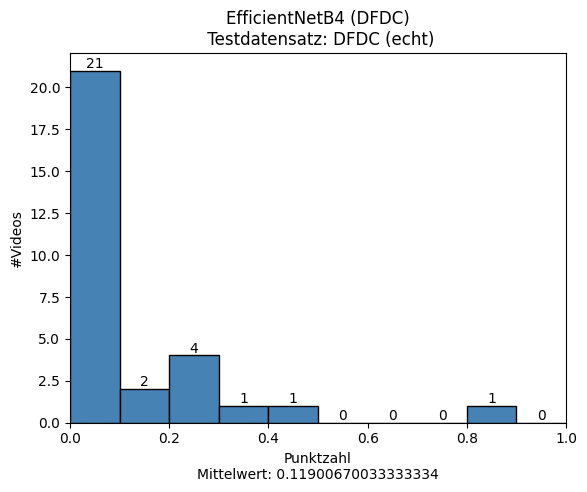

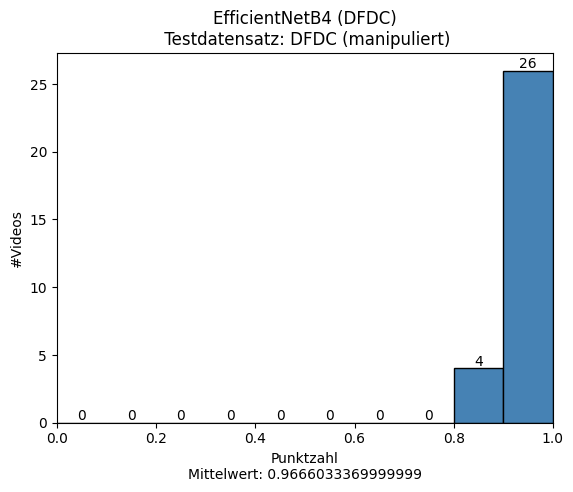

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(enet_dfdc_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_dfdc_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(enet_dfdc_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_dfdc_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

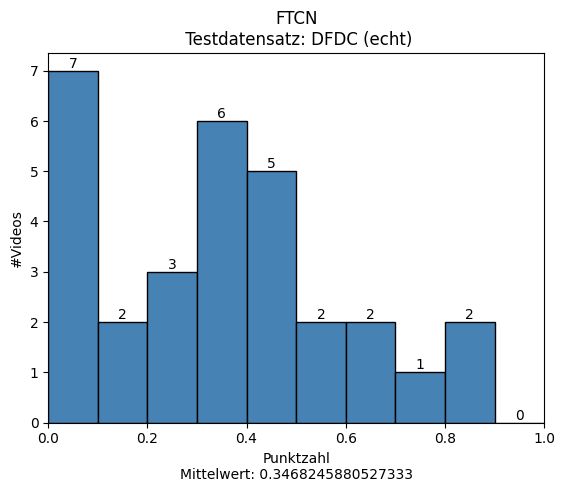

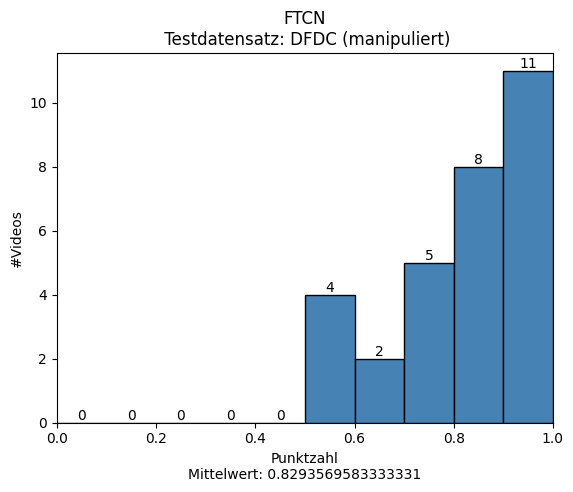

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(ftcn_dfdc_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_dfdc_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(ftcn_dfdc_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_dfdc_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

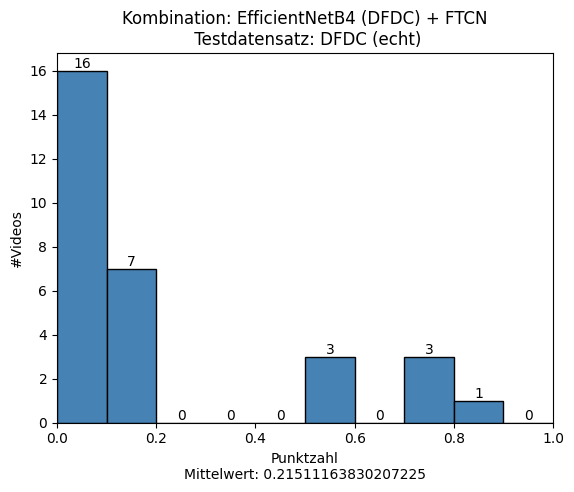

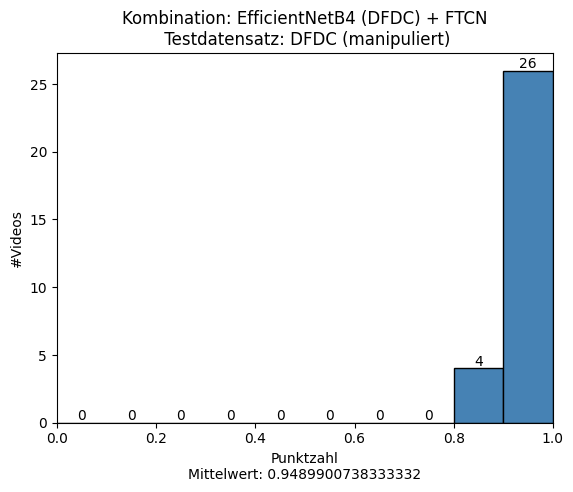

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(combined_dfdc_scores_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_dfdc_scores_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(combined_dfdc_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_dfdc_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(combined_dfdc_scores_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_dfdc_scores_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_dfdc_scores_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_dfdc_scores_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

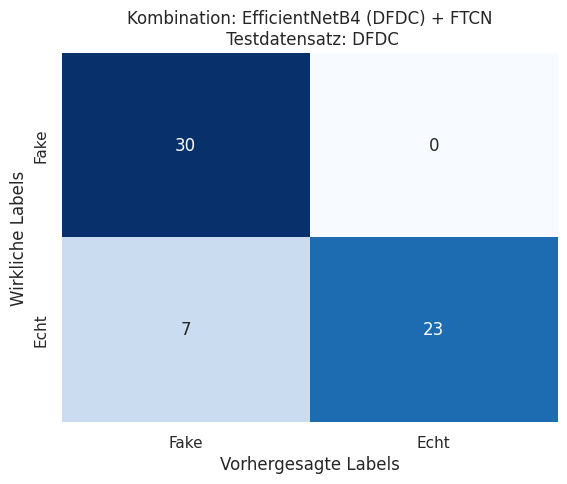

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

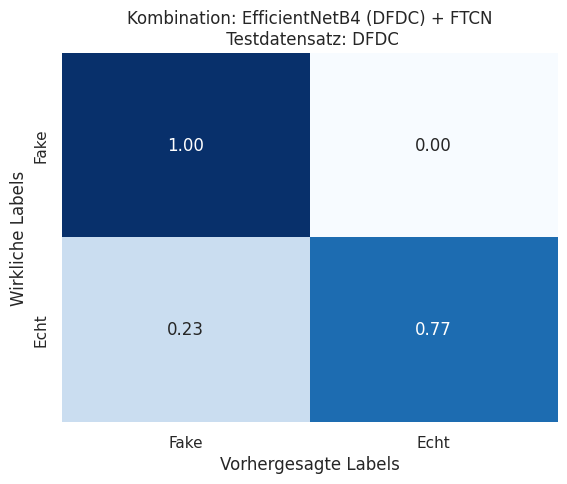

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

#### ROC AUC

In [ ]:
lables = []

for i in range(len(combined_dfdc_scores_real)):
  lables.append(0)
for i in range(len(combined_dfdc_scores_fake)):
  lables.append(1)

combined_all_predictions = np.append(combined_dfdc_scores_real, combined_dfdc_scores_fake)
efficient_all_predictions = np.append(enet_dfdc_scores_real, enet_dfdc_scores_fake)
ftcn_all_predictions = np.append(ftcn_dfdc_scores_real, ftcn_dfdc_scores_fake)

In [ ]:
combined_auc = roc_auc_score(lables, combined_all_predictions)
combined_auc_fpr, combined_auc_tpr, combined_auc_thresholds = roc_curve(lables, combined_all_predictions, pos_label=1)

efficient_auc = roc_auc_score(lables, efficient_all_predictions)
efficient_auc_fpr, efficient_auc_tpr, efficient_auc_thresholds = roc_curve(lables, efficient_all_predictions, pos_label=1)

ftcn_auc = roc_auc_score(lables, ftcn_all_predictions)
ftcn_auc_fpr, ftcn_auc_tpr, ftcn_auc_thresholds = roc_curve(lables, ftcn_all_predictions, pos_label=1)

Optimaler Threshold: 0.85423162


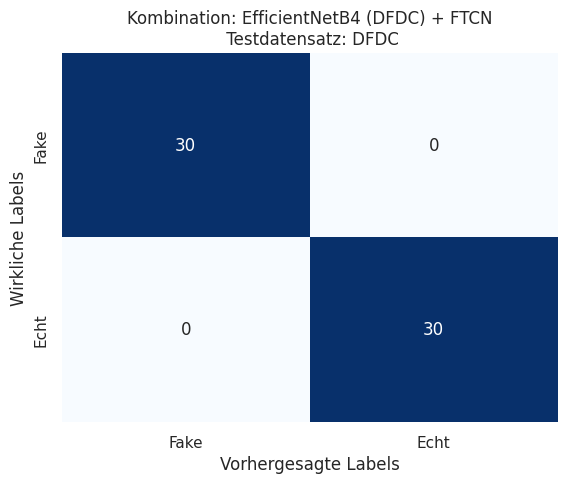

In [ ]:
optimal_idx = np.argmax(combined_auc_tpr - combined_auc_fpr)
optimal_threshold = combined_auc_thresholds[optimal_idx]
print(f"Optimaler Threshold: {optimal_threshold}")

# Getting Data
TP = np.sum(combined_dfdc_scores_fake >= optimal_threshold) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_dfdc_scores_fake < optimal_threshold) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(combined_dfdc_scores_real >= optimal_threshold) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(combined_dfdc_scores_real < optimal_threshold) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

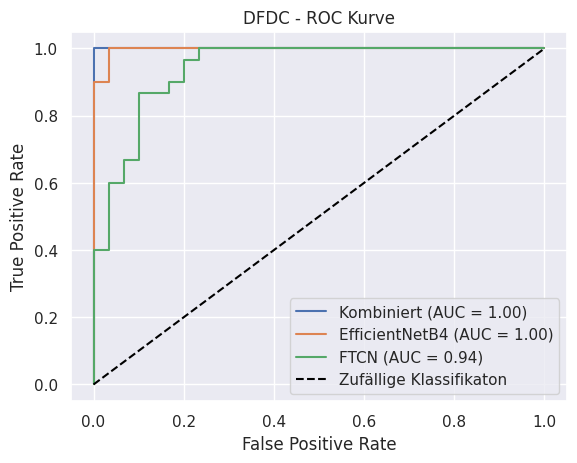

In [ ]:
plt.plot(combined_auc_fpr, combined_auc_tpr, label=f'Kombiniert (AUC = %0.2f)' % combined_auc)
plt.plot(efficient_auc_fpr, efficient_auc_tpr, label=f'EfficientNetB4 (AUC = %0.2f)' % efficient_auc)
plt.plot(ftcn_auc_fpr, ftcn_auc_tpr, label=f'FTCN (AUC = %0.2f)' % ftcn_auc)

# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Zufällige Klassifikaton')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{dataset} - ROC Kurve')
plt.legend(loc="lower right")
plt.show()

# VASA

In [ ]:
vasa_dir = "/content/deepfake_detection_datasets/VASA-1"
dataset = "VASA-1"

In [ ]:
def detect_vasa_deepfake(deepfake_folder):
  ftcn_scores = np.array([]);
  enet_scores = np.array([]);

  for deepfake in tqdm(os.listdir(deepfake_folder)):
    if deepfake.endswith('5.mp4'):
      vid_path = os.path.join(deepfake_folder, deepfake)
      vid = face_extractor.process_video(vid_path)

      # For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
      faces_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid if len(frame['faces'])] )

      with torch.no_grad():
          enet_faces_pred = net(faces_t.to(device)).cpu().numpy().flatten()

      ftcn_faces_pred, _, _, _ = predict_deepfake_video(vid_path, "/content/FTCN/checkpoints/ftcn_tt.pth")

      enet_scores = np.append(enet_scores, expit(enet_faces_pred.mean()))
      ftcn_scores = np.append(ftcn_scores, ftcn_faces_pred.mean())
  return ftcn_scores, enet_scores

In [ ]:
ftcn_vasa_score_fake, enet_vasa_score_fake = detect_vasa_deepfake(vasa_dir)
score_real = np.array([])

In [ ]:
combined_vasa_scores_real, combined_vasa_scores_fake = get_combined_scores_threshold(0.9, score_real, enet_vasa_score_fake,
                                                                                    score_real, ftcn_vasa_score_fake, 4)

In [ ]:
score_real = np.array([])
ftcn_vasa_score_fake = np.array([3.60466528e-04, 2.37515625e-04, 4.49873056e-04, 3.32210054e-03,
                                2.54002797e-04, 8.25396108e-05, 1.54359852e-04, 2.89839951e-04,
                                1.86614557e-03, 7.82882664e-05, 3.12802007e-03, 1.40035306e-04,
                                3.79338212e-03, 1.94600517e-04, 0.00425602])
enet_vasa_score_fake = np.array([0.05932766, 0.02158762, 0.01397655, 0.02836541, 0.20032004,
                                0.12523183, 0.06465456, 0.68541181, 0.01257574, 0.28719282,
                                0.00726272, 0.24408193, 0.00543474, 0.01537149, 0.02049861])

In [ ]:
combined_vasa_scores_fake

array([0.04753422, 0.0173176 , 0.01127121, 0.02335675, 0.16030683,
       0.10020197, 0.05175452, 0.54838742, 0.01043382, 0.22976991,
       0.00643578, 0.19529355, 0.00510647, 0.01233611, 0.01725009])

### Create Diagrams

In [ ]:
dataset = "VASA-1"

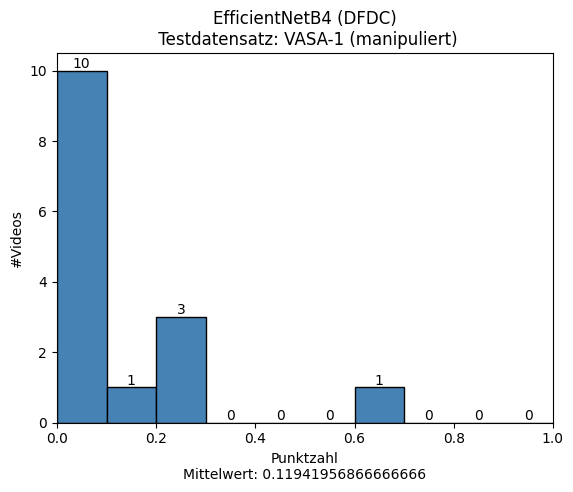

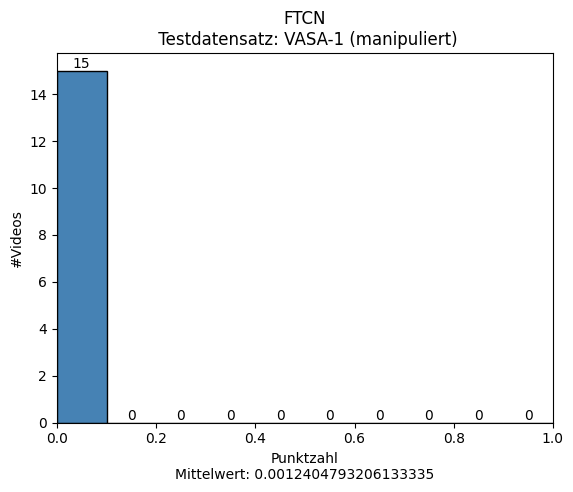

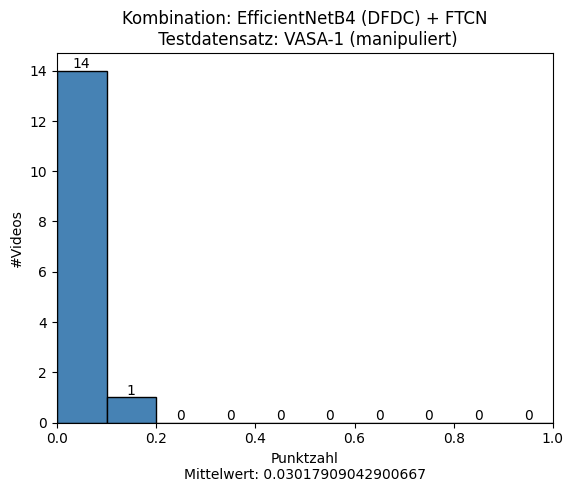

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')
_, _, bars = plt.hist(enet_vasa_score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'EfficientNetB4 (DFDC)\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {enet_vasa_score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(ftcn_vasa_score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {ftcn_vasa_score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(combined_vasa_scores_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {combined_vasa_scores_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(combined_vasa_scores_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(combined_vasa_scores_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(score_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(score_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

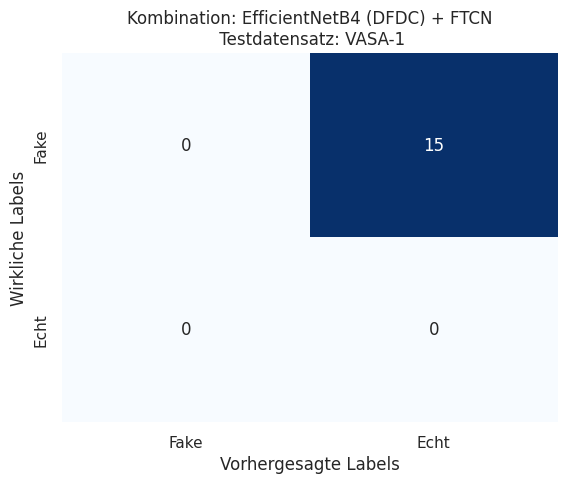

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

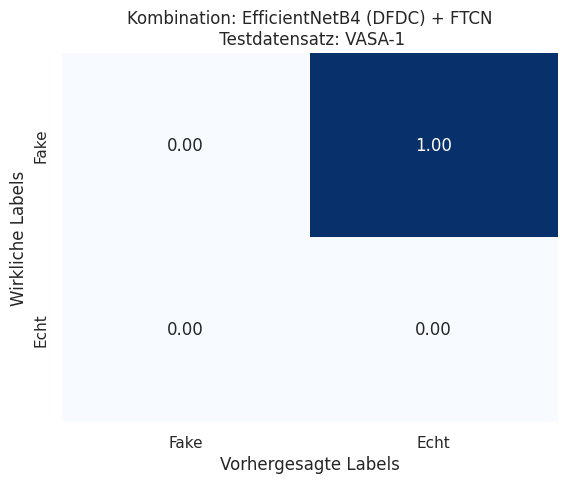

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'Kombination: EfficientNetB4 (DFDC) + FTCN\n Testdatensatz: {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

# ROC_AUC (Kombiniert)

In [ ]:
celeb_lables = []

for i in range(len(combined_celeb_scores_real)):
  celeb_lables.append(0)
for i in range(len(combined_celeb_scores_fake)):
  celeb_lables.append(1)

celeb_combined_all_predictions = np.append(combined_celeb_scores_real, combined_celeb_scores_fake)
celeb_combined_auc = roc_auc_score(celeb_lables, celeb_combined_all_predictions)
celeb_combined_auc_fpr, celeb_combined_auc_tpr, celeb_combined_auc_thresholds = roc_curve(celeb_lables, celeb_combined_all_predictions, pos_label=1)

In [ ]:
fakeav_lables = []

for i in range(len(combined_fakeav_scores_real)):
  fakeav_lables.append(0)
for i in range(len(combined_fakeav_scores_fake)):
  fakeav_lables.append(1)

fakeav_combined_all_predictions = np.append(combined_fakeav_scores_real, combined_fakeav_scores_fake)
fakeav_combined_auc = roc_auc_score(fakeav_lables, fakeav_combined_all_predictions)
fakeav_combined_auc_fpr, fakeav_combined_auc_tpr, fakeav_combined_auc_thresholds = roc_curve(fakeav_lables, fakeav_combined_all_predictions, pos_label=1)

In [ ]:
ffpp_lables = []

for i in range(len(combined_ffpp_scores_real)):
  ffpp_lables.append(0)
for i in range(len(combined_ffpp_scores_fake)):
  ffpp_lables.append(1)

ffpp_combined_all_predictions = np.append(combined_ffpp_scores_real, combined_ffpp_scores_fake)
ffpp_combined_auc = roc_auc_score(ffpp_lables, ffpp_combined_all_predictions)
ffpp_combined_auc_fpr, ffpp_combined_auc_tpr, ffpp_combined_auc_thresholds = roc_curve(ffpp_lables, ffpp_combined_all_predictions, pos_label=1)

In [ ]:
dfdc_lables = []

for i in range(len(combined_dfdc_scores_real)):
  dfdc_lables.append(0)
for i in range(len(combined_dfdc_scores_fake)):
  dfdc_lables.append(1)

dfdc_combined_all_predictions = np.append(combined_dfdc_scores_real, combined_dfdc_scores_fake)
dfdc_combined_auc = roc_auc_score(dfdc_lables, dfdc_combined_all_predictions)
dfdc_combined_auc_fpr, dfdc_combined_auc_tpr, dfdc_combined_auc_thresholds = roc_curve(dfdc_lables, dfdc_combined_all_predictions, pos_label=1)

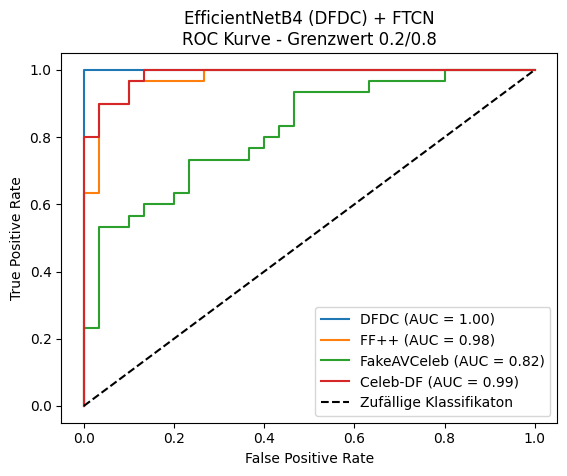

In [ ]:
# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

plt.plot(dfdc_combined_auc_fpr, dfdc_combined_auc_tpr, label=f'DFDC (AUC = %0.2f)' % dfdc_combined_auc)
plt.plot(ffpp_combined_auc_fpr, ffpp_combined_auc_tpr, label=f'FF++ (AUC = %0.2f)' % ffpp_combined_auc)
plt.plot(fakeav_combined_auc_fpr, fakeav_combined_auc_tpr, label=f'FakeAVCeleb (AUC = %0.2f)' % fakeav_combined_auc)
plt.plot(celeb_combined_auc_fpr, celeb_combined_auc_tpr, label=f'Celeb-DF (AUC = %0.2f)' % celeb_combined_auc)


# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Zufällige Klassifikaton')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'EfficientNetB4 (DFDC) + FTCN\nROC Kurve - Grenzwert 0.2/0.8')
plt.legend(loc="lower right")
plt.show()

# Erkenntniss:

- ROC_AUC nicht immer die beste metrik weil sie nur zeigt wie gut ein Model die klassen von einander differenzieren kann, nicht jedoch ob die Videos der richtigen klasse zugeordnet wurden

- Ein sehr guter AUC score zeigt trotdem, dass ein Model gut ist
- Ein Mittelwertiger AUC Score zeigt aber noch nicht das ein Modell schlecht ist